# Code for Testing Other Images
Ken Iiyoshi (ki573)\
22 Sept 2019\
Instructor: Tadesse Mulugeta

In [70]:
#imports
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from matplotlib import colors

prewritt_horizontal =np.array([[1,0,-1],
                    [1,0,-1],
                    [1,0,-1]]);

prewritt_vertical =np.array([[1,1,1],
                     [0,0,0],
                     [-1,-1,-1]]);

sobel1 =np.array([[1,0,-1],
                 [2,0,-2],
                 [1,0,-1]]);

sobel2 =np.array([[1,2,1],
                  [0,0,0],
                  [-1,-2,-1]]);

gaussian =np.array([[1,1,2,2 ,2,1,1],
                    [1,2,2,4 ,2,2,1],
                    [2,2,4,8 ,4,2,2],
                    [2,4,8,16,8,4,2],
                    [2,2,4,8 ,4,2,2],
                    [1,2,2,4 ,2,2,1],
                    [1,1,2,2 ,2,1,1]]);

# read input image for edge detection
input_img = cv2.imread("test_image/img09.jpg",0);

# declare image variables based on input image size
gradient_mag = np.zeros((input_img.shape)).astype(int);
gradient_angle = np.zeros((input_img.shape)).astype(int);
quant = np.zeros((input_img.shape)).astype(int);
suppressed = np.zeros((input_img.shape)).astype(int);
binary_edge_low = np.zeros((input_img.shape)).astype(int);
binary_edge_mid = np.zeros((input_img.shape)).astype(int);
binary_edge_high = np.zeros((input_img.shape)).astype(int);

In [71]:
def filter (array,mask):
    kernel_sz = mask.shape[0];
    pad_sz = math.floor(kernel_sz/2);
    padded = np.zeros((array.shape[0]+2*pad_sz, array.shape[1]+2*pad_sz)).astype(int);
    
    # copy array content to padded matrix
    padded[pad_sz:pad_sz+array.shape[0],pad_sz:pad_sz+array.shape[1]]=array;
    
    # Put result in new array. Otherwise cv2-imported array will invert negative to positive.
    after_conv = np.zeros((array.shape)).astype(int)
    # convolve
    for i in range(pad_sz,padded.shape[0]-pad_sz):
        for j in range(pad_sz,padded.shape[1]-pad_sz):
            # cut out a window to input feed into convolution function. +1 for proper range
            window=np.zeros((mask.shape)).astype(int);
            window=padded[i-pad_sz:i+pad_sz+1,j-pad_sz:j+pad_sz+1];
    
            # prewitt filter (horizontal/vertical), otherwise gaussian
            if np.array_equal(mask,prewritt_horizontal) or np.array_equal(mask,prewritt_vertical):
                after_conv[i-pad_sz][j-pad_sz]=np.sum(np.multiply(window,mask));
            else:
                after_conv[i-pad_sz][j-pad_sz]=np.sum(np.multiply(window,mask))/np.sum(np.absolute(mask)); 
    return after_conv

# P-Tile thresholding 
def threshold(img,weak_threshold,strong_threshold,binary_edge):
    #most edge is below 255 so I chose lower value
    count=0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if (img[i][j]>=strong_threshold):
                binary_edge[i][j]=255;
                count+=1;
            elif (img[i][j]>=weak_threshold):
                binary_edge[i][j]=127;
            else:
                binary_edge[i][j]=0;
                
    # Edge tracking by hysteresis
    for i in range(binary_edge.shape[0]):
        for j in range(binary_edge.shape[1]):
            if (binary_edge[i][j]==127):
                if (binary_edge[i-1][j-1]==255) or (binary_edge[i-1][j]==255) or (binary_edge[i-1][j+1]==255) or (img[i][j-1]==255) or (binary_edge[i][j]==255) or (binary_edge[i][j+1]==255) or (binary_edge[i+1][j-1]==255) or (binary_edge[i+1][j]==255) or (binary_edge[i+1][j+1]==255):
                    binary_edge[i][j]=255;
                    count+=1;
                else:
                    binary_edge[i][j]=0;
                    
    print("Edge Pixel Count for strong_threshold = ",strong_threshold,", weak_threshold =", weak_threshold,":",count)
    print("\tEdge/Image Size Percentage:", round(100*count/binary_edge.size,1),"%")
    
    return binary_edge

In [72]:
# Gaussian Smoothing
print("Input size:", input_img.shape)
output=filter(input_img,gaussian)
cv2.imwrite('results/other_images/smooth.png',output)

# Gradient Operation
smooth = cv2.imread("results/other_images/smooth.png",0);
gradient_horizontal=filter(smooth,prewritt_horizontal);
cv2.imwrite('results/other_images/gradient_horizontal.png',gradient_horizontal);
gradient_vertical=filter(smooth,prewritt_vertical);
cv2.imwrite('results/other_images/gradient_vertical.png',gradient_vertical);

## Non-Maximum Suppression

# Gradient Magnitude & Direction
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        gradient_mag[i][j]=int((gradient_horizontal[i][j]**2+gradient_vertical[i][j]**2)**(1/2));
        if (gradient_horizontal[i][j]!=0):
            #arctan is in radians. multiply by 180/pi dy/dx
            gradient_angle[i][j]=(180/math.pi)*np.arctan(gradient_vertical[i][j]/gradient_horizontal[i][j]);
        #if dx=0, result is -90 or 90
        elif (gradient_vertical[i][j]>0):
            gradient_angle[i][j]=90;
        elif (gradient_vertical[i][j]<0):
            gradient_angle[i][j]=-90;
        # 0 if both dx and dy is 0
        else:
            gradient_angle[i][j]=0

cv2.imwrite('results/other_images/gradient_mag.png',gradient_mag);

# Quantization bounds:
# 2:more than 67.5 or less than -67.5
# 1:22.5~67.5
# 0: -22.5~22.5
# 3:-67.5~-22.5
for i in range(input_img.shape[0]):
    for j in range(input_img.shape[1]):
        if (gradient_angle[i][j]> 67.5) or (gradient_angle[i][j]< -67.5):
            quant[i][j]=2;
        elif gradient_angle[i][j]> 22.5:
            quant[i][j]=1;
        elif gradient_angle[i][j]> -22.5:
            quant[i][j]=0;
        else:
            quant[i][j]=3;

# Non-Maxima Suppression
# +1, -1 to keep iteration within boundary 
for i in range(1,input_img.shape[0]-1):
    # according to class lecture #2
    for j in range(1,input_img.shape[1]-1):
        if (quant[i][j]==2):
            if (gradient_mag[i][j]>gradient_mag[i-1][j]) and (gradient_mag[i][j]>gradient_mag[i+1][j]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==1):
            if (gradient_mag[i][j]>gradient_mag[i+1][j-1]) and (gradient_mag[i][j]>gradient_mag[i-1][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==0):
            if (gradient_mag[i][j]>gradient_mag[i][j-1]) and (gradient_mag[i][j]>gradient_mag[i][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        elif (quant[i][j]==3):
            if (gradient_mag[i][j]>gradient_mag[i-1][j-1]) and (gradient_mag[i][j]>gradient_mag[i+1][j+1]):
                suppressed[i][j]=gradient_mag[i][j];
        else:
            suppressed[i][j]=0
cv2.imwrite('results/other_images/suppressed.png',suppressed);


# Double thresholding: weak_threshold for 3 different values. keep stronge_threshold unchanged for now.
# test1 : edge is 1% of image area
# test2 : edge is 2% of image area
stronge_threshold=30
weak_threshold = 10 #minimum percentage of edge
binary_edge_low = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_low)
cv2.imwrite('results/other_images/binary_edge_low_threshold.png',binary_edge_low);

stronge_threshold=40
weak_threshold = 20 #minimum percentage of edge
binary_edge_mid = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_mid)
cv2.imwrite('results/other_images/binary_edge_mid_threshold.png',binary_edge_mid);

stronge_threshold=50
weak_threshold = 30 #minimum percentage of edge
binary_edge_high = threshold(suppressed,weak_threshold, stronge_threshold, binary_edge_high)
cv2.imwrite('results/other_images/binary_edge_high_threshold.png',binary_edge_high);



Input size: (349, 720)
Edge Pixel Count for strong_threshold =  30 , weak_threshold = 10 : 19651
	Edge/Image Size Percentage: 7.8 %
Edge Pixel Count for strong_threshold =  40 , weak_threshold = 20 : 17627
	Edge/Image Size Percentage: 7.0 %
Edge Pixel Count for strong_threshold =  50 , weak_threshold = 30 : 15573
	Edge/Image Size Percentage: 6.2 %


In [73]:
def hough(img, theta_resolution, rho_resolution):

    # rho_max = img diagonal size. 
    rho_max = (img.shape[0]**2 + img.shape[1]**2)**(1/2);
    ""
    # Note: range stops 1 step short of terminating value. Hence, the ""+ rho_resolution".
    # 0 <= rho <= rho_max & -90 <= theta < 90.
    rho = np.arange(0, rho_max + rho_resolution, rho_resolution, dtype = np.float);
    # manual resolution at the moment.
    theta = np.arange(-90, 90, 1, dtype = np.float);
    print("theta size: ",len(theta))
    # Make accumulator
    accumulator = np.zeros((len(rho),len(theta))).astype(int);
    
    # move calculations outside of loop:
    y_max = img.shape[0];
    x_max = img.shape[1];
    theta_max = len(theta);
    print("img dimension: y_max =", y_max, ", x_max =", x_max);
    
    for y in range(y_max):
        for x in range(x_max):
            if (img[y][x] == 255):
                for phase in  range(-int(theta_max/2),int(theta_max/2)):
                   
                    # if line equation works:
                    p = x * math.cos(phase/180*math.pi) + y * math.sin(phase/180*math.pi);
                
                    # to ensure correct indexing
                    p_index = int(p/rho_resolution)

                    # add vote to the pixel in parameter space
                    # +1, but use higher values for debugging.
                    accumulator[p_index][phase+90] = accumulator[p_index][phase+90] + 10;

    return accumulator, theta, rho;

In [74]:
def hough_peaks(A, number_of_peaks):
        
    peaks_theta_plot = [];  # Peaks' theta coordinates
    peaks_rho_plot = [];    # Peaks' rho coordinates
    peaks_score = [];       # Peaks' scores
    detected_peaks = 0;     # for counting number of detected peaks
    r = 15;                 # radius of area suppressing neighbors  intuitively picked.
    
    # cutoff value manually set.
    cutoff = math.floor(A.max()*0.10);

    theta_max = int(A.shape[1]);
    rho_max = A.shape[0];
    
    for p in range(rho_max): # p means rho
        for d in range(theta_max): # d refers to theta
            if (A[p][d] >= cutoff):
                
                detected_peaks = detected_peaks+1;    # increment detection count
                peaks_theta_plot.append(d);
                peaks_rho_plot.append(p);
                peaks_score.append(A[p][d])
                
                # Suppress peaks according to cutoff
                A[p-r:p+r+1,d-r:d+r+1] = np.where(A[p-r:p+r+1,d-r:d+r+1] >= cutoff, 0, A[p-r:p+r+1,d-r:d+r+1]);

    print("Number of detected_peaks:", detected_peaks);
    
    # if number_of_peaks exceeds detected_peaks:
    extra_count =  detected_peaks - number_of_peaks;
    if (extra_count <= 0):
        print("number_of_peaks exceeds detected_peaks. Returning", detected_peaks, "peaks.")
        return peaks_theta_plot, peaks_rho_plot
        
    # eliminate weakest candidates.
    while (extra_count > 0):
        min_score = min(peaks_score);
        for n in range(len(peaks_score)):
            # exit for loop to move on to popping.
            if (peaks_score[n] == min_score):
                break;
        peaks_score.pop(n);
        peaks_theta_plot.pop(n);
        peaks_rho_plot.pop(n);
        extra_count = extra_count - 1;     # update count
    
    return peaks_theta_plot, peaks_rho_plot

## Result

### hough( ) and hough_peak( )

theta size:  180
img dimension: y_max = 349 , x_max = 720
Number of detected_peaks: 1882


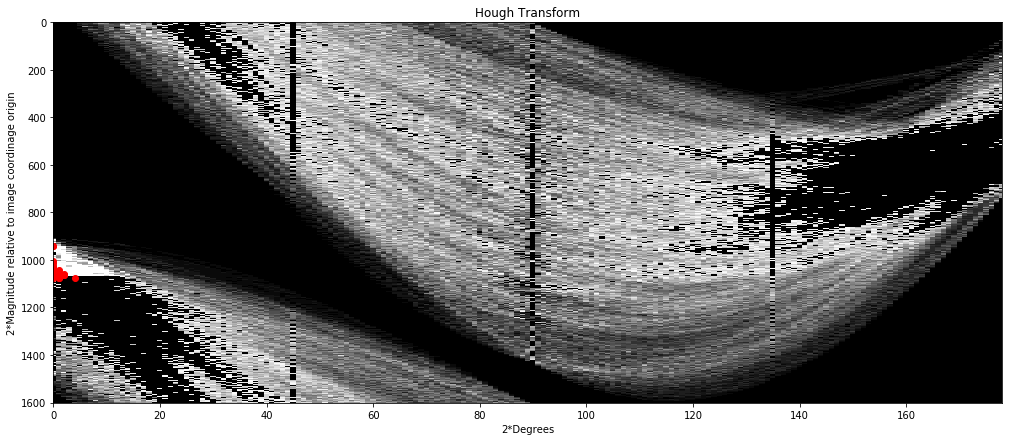

In [75]:
# Adjustable parameters:
theta_resolution = 0.5;
rho_resolution = 0.5;
number_of_peaks = 25;

# read edge-detected image, create hough image, save.
binary_img = cv2.imread("results/other_images/binary_edge_low_threshold.png",0);
A, T, R = hough(binary_img, theta_resolution, rho_resolution);
cv2.imwrite('results/other_images/accumulator.png',A);

# Detect peaks.
peaks_x_plot, peaks_y_plot = hough_peaks(A, number_of_peaks);

# # use P space indices as indices to obtain corresponding T and R
# # to take into accounf of image space resolution.
peaks_x = T[peaks_x_plot];
peaks_y = R[peaks_y_plot];


# plot
fig = plt.figure(figsize = (17,7));
plt.axis([0, 2*T.max(), 2*R.max(), 0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("2*Magnitude relative to image coordinage origin");
plt.xlabel("2*Degrees");
plt.title('Hough Transform');
plt.plot(peaks_x_plot, peaks_y_plot, 'ro')
# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(A, cmap = "gray", norm = colors.Normalize(0,255), aspect = 'auto'); 

### hough_line( )

In [76]:
def houghlines(img, peaks_x, peaks_y):
    line = [];
    
    x_max = img.shape[1]
    y_max = img.shape[0]
    
    number_of_lines = len(peaks_x);
    
    # calculate start and stop points of a line at each loop
    for i in range(number_of_lines):
        # find where the line will be placed in image space.
        # +0.01 to avoid division by zero
        #### multiply slope by -1 and offset y by - y_max to take care of flip in y-axis.
        slope = -1/math.tan((peaks_x[i] + 0.01)*math.pi/180);
        y_intercept = peaks_y[i]/math.sin((peaks_x[i] + 0.01)*math.pi/180);
        
        # make coordinates based on slope-intercept form of line equation
        # out of all the edge pixels lies in the line equation, save the left/bottom and right/top most ones.
        # choose lef and right convention for ease, so bother only with x-coordinates of peaks.
        # flag for detected lines.
        line_detection_flag = 0;
        
        # for line_start. scan starting from minimum x val.
        for x_index in range(0,x_max):
            y_index = int(x_index*slope + y_intercept);
            # if line at x=x_index appears in the img.
            if (y_index >= 0) and (y_index < y_max):
                # if corresponding edgel is an edge
                if img[y_index][x_index] == 255:
                    # if the subsequent pixel(top right, right, bottom righ) on the line equation is also an edge, this candidate not a random point, so save it.
                    if (img[y_index+1][x_index+1] == 255) or (img[y_index][x_index+1] == 255) or (img[y_index-1][x_index+1] == 255):
                        line_start = (x_index, y_index);
                        line_detection_flag = 1;
                        temp = x_index;
                        # for line_end. scan starting from same val+1.
                        for new_x_index in range(temp, x_max):
                            new_y_index = int(new_x_index*slope + y_intercept);
                            # if line at x=new_x_index appears in the img.
                            if (y_index >= 0) and (y_index < y_max):
                                # if corresponding edgel is not an edge, terminate by saving this point line_end
                                if img[new_y_index][new_x_index] != 255:
                                    # if the subsequent pixel on the line equation is also not an edge, this candidate not a random non_edge point, so save it.
                                    if (img[new_y_index+1][new_x_index+1] != 255) or (img[new_y_index][new_x_index+1] != 255) or (img[new_y_index-1][new_x_index+1] != 255):
                                        line_end = (new_x_index, new_y_index);
                                        line_detection_flag = 1;
                                        break;
                        break;

        # for lines that never appear on img, skip processing.:
        if (line_detection_flag == 0):
            number_of_lines = number_of_lines-1;
            continue;
        
        # add two coordinates as a structure
        entry = (line_start, line_end);
        line.append(entry);
    
    return line;

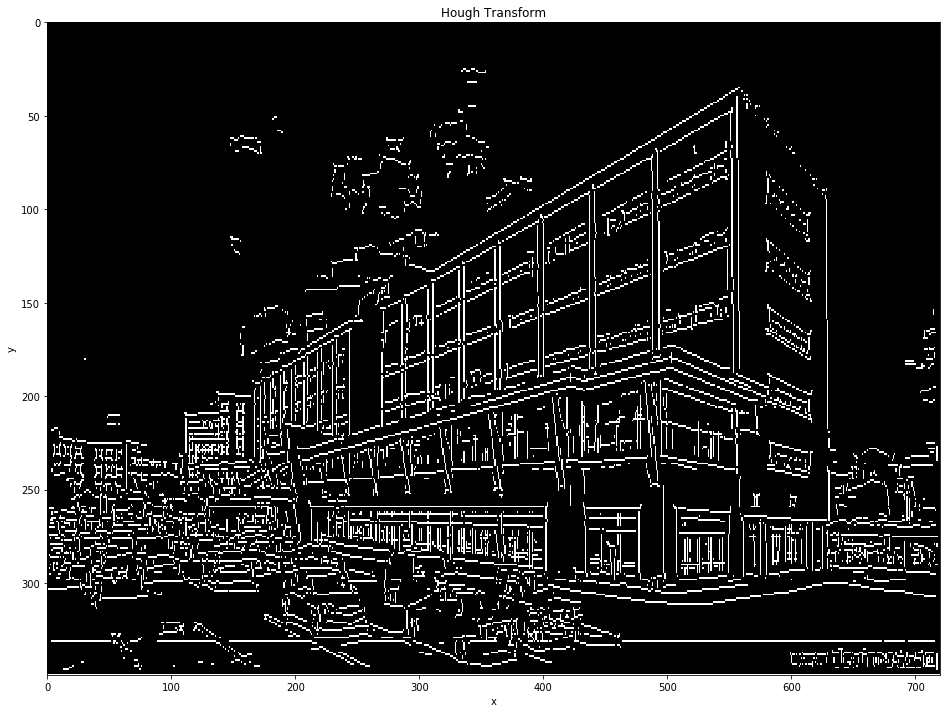

In [77]:
# get lines
lines = houghlines(binary_img, peaks_x, peaks_y) ;

# plot edge image
fig = plt.figure(figsize = (16,12));
# xmin, xmax, ymin, ymax
plt.axis([0, binary_img.shape[1], binary_img.shape[0],0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("y");
plt.xlabel("x");
plt.title('Hough Transform');


for i in range(len(lines)):
    #  inputting (start_x, end_x), (start_y, end_y)
    plt.plot((lines[i][0][0], lines[i][1][0]), (lines[i][0][1], lines[i][1][1]), 'r');

# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(binary_img, cmap = "gray", aspect = 'auto'); 


plt.savefig('results/other_images/detected_edges.png')

## Output with full lines

In [78]:
def houghlines_no_seg(img, peaks_x, peaks_y):
    line = [];
    
    x_max = img.shape[1]
    y_max = img.shape[0]

    number_of_lines = len(peaks_x);
    
    # calculate start and stop points of a line at each loop
    for i in range(number_of_lines):
        # find where the line will be placed in image space.
        # +0.01 to avoid division by zero
        #### multiply slope by -1 and offset y by - y_max to take care of flip in y-axis.
        slope = -1/math.tan((peaks_x[i] + 0.01)*math.pi/180);
        y_intercept = peaks_y[i]/math.sin((peaks_x[i] + 0.01)*math.pi/180);
        
        # make coordinates based on slope-intercept form of line equation
        line_start = (0, y_intercept);
        line_end = (x_max, x_max*slope + y_intercept);
        
        # add two coordinates as a structure
        entry = (line_start, line_end);
        line.append(entry);
    
    return line;

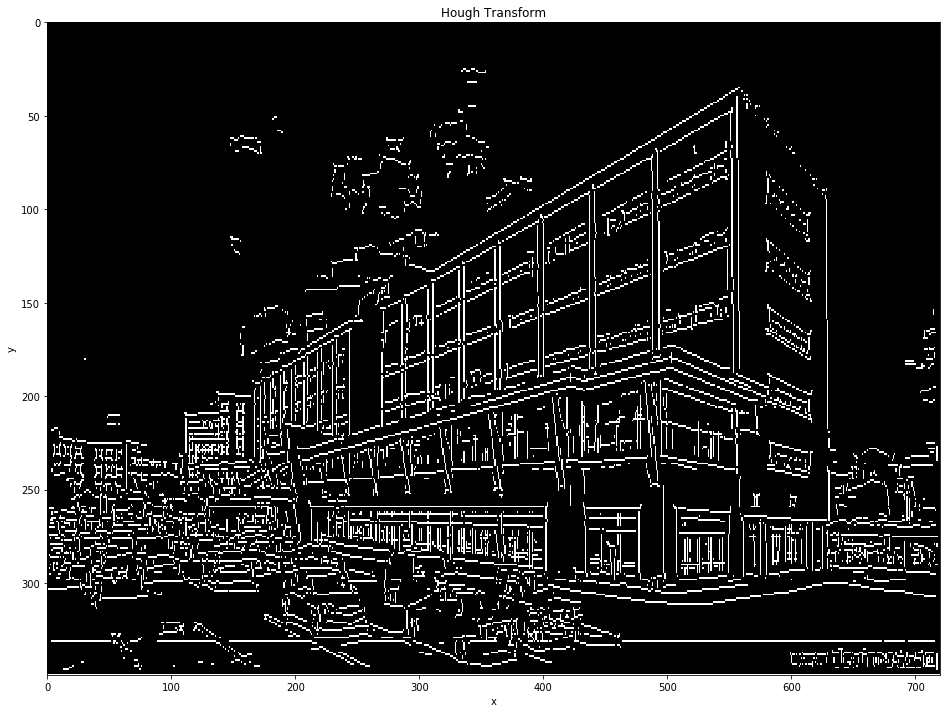

In [79]:
# get lines
lines = houghlines_no_seg(binary_img, peaks_x, peaks_y) ;

# plot edge image
fig = plt.figure(figsize = (16,12));
# xmin, xmax, ymin, ymax
plt.axis([0, binary_img.shape[1], binary_img.shape[0],0]);
# To compensate failure in adjusting y-scale, as it has to rely on the size of the rho array.
plt.ylabel("y");
plt.xlabel("x");
plt.title('Hough Transform');

# draw lines
for i in range(len(lines)):
    #  inputting (start_x, end_x), (start_y, end_y)
    plt.plot((lines[i][0][0], lines[i][1][0]), (lines[i][0][1], lines[i][1][1]), 'r');

# "A" will be normalized here, so it must be reinitialized if the code is to be reran.
plt.imshow(binary_img, cmap = "gray", aspect = 'auto'); 
plt.savefig('results/other_images/detected_edges_no_seg.png')